https://machinelearningmastery.com/what-is-bayesian-optimization/


- **Samples**: often defined as a vector of variables with predifined ranges, within which the optimal set of variables is searched for.
- **cost**: Optimization is often described in terms of minimizing cost. 
- **objective function**: The *unknown*(black box) function we want to optimize. May be computationally expensive, noisy, high dimension, non-convex,... "ill-behaved". 
Non-convex means multiple local extrema, hence "global" optimization problem

## Bayesian Optimization

By Bayes rule,  
$P(f|D) \propto P(D|f) * P(f)$, where the denominator P(D) is ignored since we are not interested in the exact probablity but want to find where the maximum occurs.

- **surrogate function**: Bayesian approximation of the obejctive function that can be effectively sampled.

We want to pick the next sampling point that will likely pay off the most. 

- **acquisition function**: the method that selects the next sampling point.

The optimization loop consists of: 
1. Select a Sample by Optimizing the acquisition function
2. Evaluate the sample with the objective function
3. Update the data and, in turn, the surrogate function

## Test Problem: fit a simple function

### Problem setting

#### The function
$ y = x^{2} sin(5 \pi x)^{6}, \quad {x \in \mathbb{R}:a<x<b}$  
\+ Gaussian Noise


In [74]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import scipy

def obj_function(x, noise=0.1):
    """Just to produce example sample data. This is "unknown" to the solver"""
    return (x**2 * np.sin(5*math.pi * x)**6.0) + noise * np.random.randn(len(x))

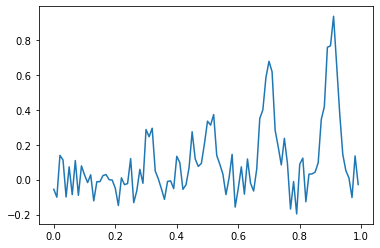

In [76]:
X = np.arange(0, 1, 0.01)
y = obj_function(X)

# For tutorial purpose
# Check what it looks like
plt.plot(X, y)
plt.show()


In [77]:
# For tutorial purpose
# know the answer
clean_y = obj_function(X, noise=0)
ix = np.argmax(clean_y)
print(f"Optima: X={X[ix]}, y={clean_y[ix]}")

Optima: X=0.9, y=0.81


### Surrogate function

Surrogate function approxiates the 'blackbox' mapping of input data $D$ to output score.
> A number of techniques can be used for this, although the most popular is to treat the problem as a regression predictive modeling problem with the data representing the input and the score representing the output to the model. This is often best modeled using a random forest or a Gaussian Process.  
A Gaussian Process, or GP, is a model that constructs a **joint probability distribution over the variables**, assuming a multivariate Gaussian distribution. As such, it is capable of efficient and effective summarization of a large number of functions and smooth transition as more observations are made available to the model.  
This **smooth structure and smooth transition to new functions based on data are desirable properties** as we sample the domain, and the multivariate Gaussian basis to the model means that an estimate from the model will be a mean of a distribution with a standard deviation; that will be helpful later in the acquisition function.  
As such, using a GP regression model is often preferred.


So, we use GaussianProcessRegressor as a surrogate function.   
## And, What does it exactly do? 

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor

model = GaussianProcessRegressor() # based on algorithm 2.1 of GPML by Rasmussen and Williams

X = X.reshape(-1,1) # Make 2D. [n_samples, n_features] # We have only one feature.
y = y.reshape(-1,1)

model.fit(X,y)

GaussianProcessRegressor()

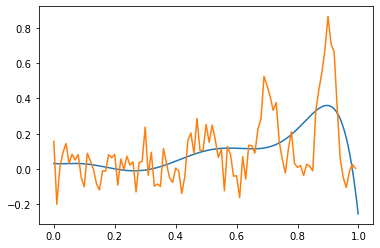

In [16]:
from warnings import catch_warnings
from warnings import simplefilter

Xsamples = np.asarray(np.arange(0, 1, 0.001))
Xsamples = Xsamples.reshape(-1, 1)

def surrogate(model, X):
    """
    basically model.predict. That is, *surrogate function* == *model*
    """
    with catch_warnings():
        simplefilter('ignore')
        return model.predict(X, return_std=True)
    

ysamples, _ = surrogate(model, Xsamples)

plt.plot(Xsamples, ysamples)
plt.plot(X.flatten(), y.flatten())
plt.show()

### Acquisition Function & Optimization strategy

The first try to model the distribution as a .... ***multiple chained Gaussian functions??*** looks not too bad. 

Equipped With the surrogate function, we now explore the "response" space of the surrogate function (instead of running expensive blackbox object function) For the searching, **BFGS algorithm** is one of the most popular optimization strategy, but we will simply do random search here.

We proceed by adding a new data point one (or few) by one by carefully choosing a new point to be evaluated byh the blackbox objective function.

How do we *carefully* choose a point? 
evaluate many points with the surrogate function(a much cheaper proxy of the obj function), and pick one point based on performance. 
**Performance** here can be measured in various ways. Among many, most common choices are 
1. Probability of Improvement (PI)
2. Expected Improvement (EI)
3. Lower Confidence Bound (LCB)

In other words, the acquisition fuction tries to identify a point evaluating upon which will

1. mostly likely to improve the certainty of the surrogate function or  
2. maximally improve the certainty of the surrogate function 
3. ...?


We choose the most simple one, PI:
$$ PI = CDF(\mu - \mu_{best} / \sigma) $$


**BFGS algorithm** is one of the most popular optimization strategy, but we will simply do random search here.



In [78]:
# draw random samples from the domain, evaluate, and choose one with the best score. 
from scipy.stats import norm

def opt_acquision(X, y, model):
    """
    The acqusition function tries to figure out 
    which point is most effective/economic to evaluate with the object function
    """
    # random sampling, instead of BFGS algorithm    
    Xsamples = np.random.random(100)
    Xsamples = Xsamples.reshape(-1,1)
    # calculate the acquisition function for each sample    
    scores = acquisition(X, Xsamples, model)
    # pick the one with the highest 'acquisition score', or most poorly constrained point.
    ix = np.argmax(scores)
    return Xsamples[ix, 0]

def acquisition(X, Xsamples, model):
    """
    We use PI, the simplest acqusition function.
    """
    yhat, _ = surrogate(model, X) 
    # X will be updated every iteration. 
    # Don't worry too much. 
    # We won't go through too many iterations.
    current_best = np.max(yhat)
    # new
    mu, std = surrogate(model, Xsamples)
    mu = mu[:,0]
    # Probability of Improvement
    probs = norm.cdf((mu - current_best) / (std+1e-9))
    return probs

Do PI, EI and LCB apply only to GP models? -- Unlikely! 

## Complete program

In [79]:
def plot(X, y, model, color_cut=100):
    # scatter plot of inputs and real objective function
    if len(X) > color_cut:
        c = np.ones(len(X))
        c[color_cut:] = np.arange(len(X)-color_cut)
    else:
        c = None
    plt.scatter(X, y, c=c)
    # line plot of surrogate function across domain
    Xsamples = np.arange(0, 1, 0.001)
    Xsamples = Xsamples.reshape(-1, 1)
    ysamples, _ = surrogate(model, Xsamples)
    plt.plot(Xsamples, ysamples)
    # show the plot
    plt.show()

In [123]:
X_ans = np.arange(0, 1, 0.001)
y_ans = obj_function(X_ans) 

# best result
clean_y = obj_function(X_ans, noise=0)
ix = np.argmax(clean_y)
print(f"ANSWER: X={X_ans[ix]}, y={clean_y[ix]}")

ANSWER: X=0.901, y=0.811200286049608


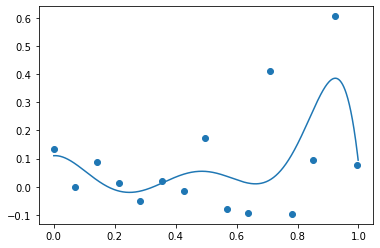

>x=0.92229, f()=0.385562, actual=0.71545
>x=0.25231, f()=-0.032479, actual=-0.03739
>x=0.23391, f()=-0.033402, actual=-0.01385
>x=0.92322, f()=0.511731, actual=0.55962
>x=0.89841, f()=0.496574, actual=0.79701
>x=0.90471, f()=0.572287, actual=0.56149
>x=0.85512, f()=0.424292, actual=0.01689
>x=0.91748, f()=0.545772, actual=0.81497
>x=0.93474, f()=0.591673, actual=0.39769
>x=0.92461, f()=0.565747, actual=0.57109


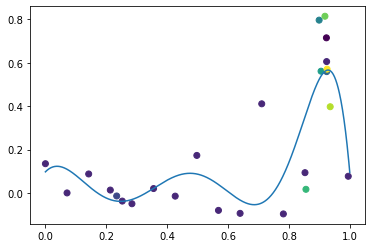

>x=0.02315, f()=0.119501, actual=-0.02310
>x=0.92475, f()=0.565909, actual=0.43573
>x=0.01172, f()=0.059229, actual=0.02646
>x=0.17003, f()=-0.004562, actual=0.04594
>x=0.92575, f()=0.552451, actual=0.43432
>x=0.92766, f()=0.541145, actual=0.71112
>x=0.59317, f()=0.012288, actual=0.06547
>x=0.92771, f()=0.556227, actual=0.51409
>x=0.88199, f()=0.460109, actual=0.61843
>x=0.25832, f()=-0.026882, actual=0.09540


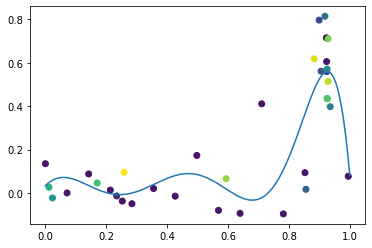

>x=0.67168, f()=-0.032475, actual=0.29251
>x=0.51308, f()=0.095191, actual=0.36048
>x=0.92580, f()=0.556684, actual=0.54561
>x=0.74872, f()=0.080619, actual=0.09731
>x=0.18881, f()=0.003926, actual=-0.08758
>x=0.90129, f()=0.528568, actual=0.68313
>x=0.51010, f()=0.152263, actual=0.18400
>x=0.92670, f()=0.564324, actual=0.53511
>x=0.78562, f()=0.163358, actual=0.05302
>x=0.93607, f()=0.556915, actual=0.33210


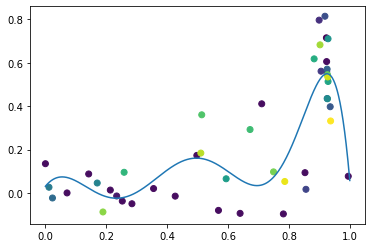

>x=0.90944, f()=0.538869, actual=0.77690
>x=0.93455, f()=0.554242, actual=0.33169
>x=0.92190, f()=0.550231, actual=0.48233
>x=0.91555, f()=0.544835, actual=0.72020
>x=0.92822, f()=0.552381, actual=0.60522
>x=0.93888, f()=0.538975, actual=0.30457
>x=0.93114, f()=0.540180, actual=0.28330
>x=0.91014, f()=0.533661, actual=0.74720
>x=0.91708, f()=0.545815, actual=0.68125
>x=0.90786, f()=0.545868, actual=0.70698


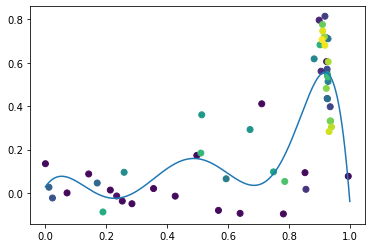

>x=0.91906, f()=0.556821, actual=0.78035
>x=0.93307, f()=0.549607, actual=0.36898
>x=0.90949, f()=0.556656, actual=0.77158
>x=0.94271, f()=0.518704, actual=0.20680
>x=0.91627, f()=0.558503, actual=0.80218
>x=0.89170, f()=0.545029, actual=0.81107
>x=0.16056, f()=-0.000273, actual=0.14167
>x=0.90664, f()=0.574608, actual=0.77652
>x=0.89648, f()=0.571816, actual=0.83531
>x=0.92392, f()=0.577771, actual=0.55935


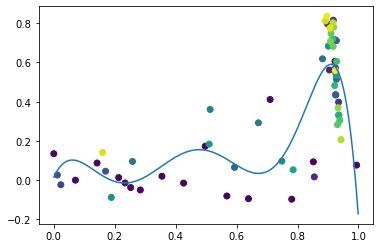

>x=0.92405, f()=0.577000, actual=0.58211
>x=0.94864, f()=0.480078, actual=0.30711
>x=0.93793, f()=0.527351, actual=0.40265
>x=0.88351, f()=0.559920, actual=0.65761
>x=0.90491, f()=0.589822, actual=0.73977
>x=0.90353, f()=0.593980, actual=0.83485
>x=0.91822, f()=0.591050, actual=0.69688
>x=0.89474, f()=0.597722, actual=0.85746
>x=0.92356, f()=0.587439, actual=0.51083
>x=0.90680, f()=0.609449, actual=0.71498


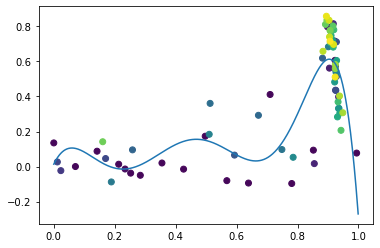

>x=0.90966, f()=0.610633, actual=0.65141
>x=0.90494, f()=0.613523, actual=0.80137
>x=0.90686, f()=0.617640, actual=0.78823
>x=0.89924, f()=0.621560, actual=0.81517
>x=0.89662, f()=0.625395, actual=0.83379
>x=0.90474, f()=0.632272, actual=0.88838
>x=0.88125, f()=0.617465, actual=0.51740
>x=0.90056, f()=0.635886, actual=0.96274
>x=0.88774, f()=0.633519, actual=0.59147
>x=0.90245, f()=0.642447, actual=0.83642


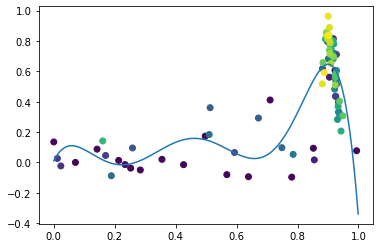

>x=0.86132, f()=0.572511, actual=0.19557
>x=0.90378, f()=0.637787, actual=0.78975
>x=0.91725, f()=0.628490, actual=0.60683
>x=0.91483, f()=0.632244, actual=0.58262
>x=0.90222, f()=0.639477, actual=0.85490
>x=0.89239, f()=0.636780, actual=0.68440
>x=0.86242, f()=0.564503, actual=0.20554
>x=0.90750, f()=0.637598, actual=0.83573
>x=0.91009, f()=0.639803, actual=0.77308
>x=0.90891, f()=0.642628, actual=0.75758


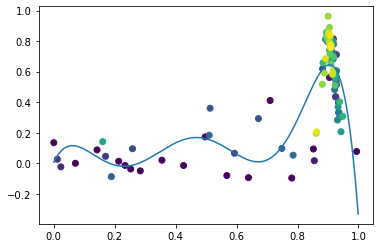

>x=0.90698, f()=0.645142, actual=0.66875
>x=0.91831, f()=0.633898, actual=0.78981
>x=0.93821, f()=0.562860, actual=0.28860
>x=0.89930, f()=0.644054, actual=0.74668
>x=0.88788, f()=0.631805, actual=0.63816
>x=0.90650, f()=0.647100, actual=0.84383
>x=0.89629, f()=0.646826, actual=0.79062
>x=0.89528, f()=0.648487, actual=0.97403
>x=0.55659, f()=0.106655, actual=-0.03011
>x=0.87926, f()=0.627565, actual=0.58170


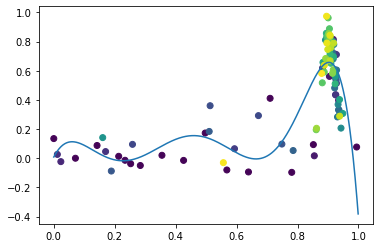

>x=0.88714, f()=0.643110, actual=0.68614
>x=0.92843, f()=0.607981, actual=0.43168
>x=0.90586, f()=0.655853, actual=0.54209
>x=0.88727, f()=0.641870, actual=0.61026
>x=0.60892, f()=0.027695, actual=-0.06714
>x=0.92445, f()=0.618408, actual=0.48561
>x=0.89368, f()=0.649391, actual=0.84333
>x=0.91533, f()=0.643179, actual=0.76065
>x=0.88674, f()=0.644760, actual=0.75858
>x=0.90836, f()=0.656351, actual=1.02729


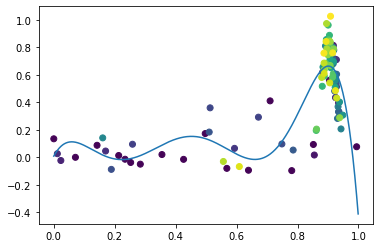

In [124]:
model = GaussianProcessRegressor() # based on algorithm 2.1 of GPML by Rasmussen and Williams

# Only limited sampling of the truth is given.
X = X_ans[::71]
y = y_ans[::71]

color_cut = len(X)
X = X.reshape(-1,1) # Make 2D. [n_samples, n_features] # We have only one feature.
y = y.reshape(-1,1)

model.fit(X,y)
plot(X, y, model)

for i in range(100):
    # next point to evaluate
    x = np.array([opt_acquision(X, y, model)])
    # evalute the poicnt
    new_data = obj_function(x) # This can be any blackbox function / external procedure / ....
    # summarize the finding
    est, _ = surrogate(model, x.reshape(-1,1))
    print('>x=%.5f, f()=%5f, actual=%.5f' % (x, est, new_data))
    # add the data to the dataset
    X = np.vstack((X, x))
    y = np.vstack((y, new_data))
    # update the model
    model.fit(X, y)
    if i % 10 == 9:
        plot(X, y, model, color_cut=color_cut)


colored points are newly assessed ones by Bayesian Optimization process. 

In [125]:
# best result
ix = np.argmax(y)
print('Best Result: x=%.5f, y=%.5f' % (X[ix], y[ix]))

Best Result: x=0.90836, y=1.02729


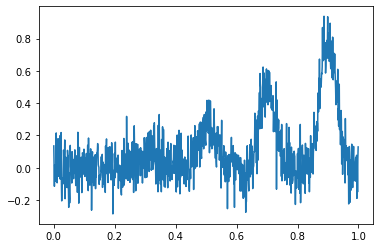

In [127]:
# The original NOISY data
plt.plot(X_ans, y_ans)
plt.show()

### Discussion
Remember that our goal was to find the maximum of the blackbox function. By sampling more points around x=0.9, BO found a point very close to the real maximum, which wasn't present in the initial prior.

In [ ]:
http://vu-nguyen.org/BOTutorial_ACML20.html#slides